In [ ]:
%pip install matplotlib
%pip install numpy
%pip install qutip
%pip install imageio

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.3/16.3 MB 74.0 MB/s eta 0:00:00


In [ ]:
import matplotlib as mpl
from pylab import *
from matplotlib import cm
import imageio
import numpy as np
import matplotlib.pyplot as plt
from qutip import *
from IPython.display import Image, Math, Latex, display

/usr/local/lib/python3.10/dist-packages/qutip/__init__.py:65: UserWarning: The new version of Cython, (>= 3.0.0) is not supported.
  warnings.warn(


<h2>
    <center>
        General Ramsey Spectroscopy
    </center>
</h2>

Suppose that we have a pulse with turn-on time much faster than the time scale of the system. According to [Wikipedia](https://en.wikipedia.org/wiki/Bloch_sphere) a rotation about the $y$-axis of the Bloch sphere can be written as

$$
R_x(\theta) = \cos(\theta/2) \mathbb{I} - i \sin(\theta/2) \sigma_x
$$

where $\theta$ is the rotation angle of the qubit state, $\mathbb{I}$ is the identity operator, and $\sigma_x = \sigma + \sigma^\dagger$. The duration of a $\pi$-pulse is then given by $\tau = \pi/\Omega$ where $\Omega$ is the Rabi frequency.

In [ ]:
def qsum(op_list):
    op = op_list[0]*0
    for op_i in op_list:
        op += op_i
    return op

class N_dipole_system:
    def __init__(self, N):
        # Number of atoms
        self.N = N

        ### annihilation operators ###
        idatom = qeye(2)  # identity operator
        sm = projection(2, 0, 1)  # |1><0| for an Ns-state system

        self.sm_list = []
        for i in range(N):
            op_list = [idatom] * N
            op_list[i] = sm
            self.sm_list.append(tensor(op_list))
        self.sz_list = [
            sm.dag() * sm - sm * sm.dag() for sm in self.sm_list
        ]


        ### initial states ###
        self.ket_excited = tensor([basis(2,1) for _ in range(self.N)])
        self.ket_ground = tensor([basis(2,0) for _ in range(self.N)])

        # total spin operators
        self.id_tot = tensor([qeye(2)] * N)
        self.sm_tot = self.ket_ground * self.ket_excited.dag()
        self.sp_tot = self.sm_tot.dag()
        self.sz_tot = self.sp_tot * self.sm_tot - self.sm_tot * self.sp_tot
        self.sx_tot = self.sp_tot + self.sm_tot

        # list of states
        self.states = []
        self.H = []

    def pulse_sequence(self, tau, theta_list, e_op=None, points_pulse=2, points_evolve=2):
      """
      This function runs a sequence of pulses given in theta_list.
      In between each pulse, the system evolves for a time tau.
      The function returns the expectation value of the operator e_op for the final state.
      The inputs "points_pulse" and "points_evolve" prescribe the number of points at which to compute the wavefunction during the pulse and evolution.
      """
        if e_op is None:
            e_op = self.ket_excited * self.ket_excited.dag()
        self.states = [self.ket_ground]
        for n, theta in enumerate(theta_list):
            self.evolve_pulse(np.linspace(0,1,points_pulse), Omega=theta)
            if n != len(theta_list) - 1:
                self.evolve(np.linspace(0,tau,points_evolve))
        return expect(e_op, self.states[-1])

    def evolve_pulse(self, tlist, Omega=None, c_ops=[]):
        if Omega==None:
          Omega = [1] * self.N
        H = self.H * 0
        for i, sm in enumerate(self.sm_list):
            H += Omega[i]/2*(sm + sm.dag())
        psi0 = self.states[-1]
        self.states += mesolve(H, psi0, tlist, c_ops=c_ops).states
        return self.states[-1]

    def evolve(self, tlist, c_ops=[]):
        psi0 = self.states[-1]
        self.states += mesolve(self.H, psi0, tlist, c_ops=c_ops).states
        return self.states[-1]

    def animate_bloch(self, fname, duration=1, save_all=False):
        n_states_to_plot = 10
        b = Bloch()
        b.vector_color = list(cm.Set1(np.linspace(0, 1, 9)))
        b.view = [-40,30]
        images=[]
        length = len(self.states)

        ### customize the Bloch sphere ###
        nrm = mpl.colors.Normalize(0,n_states_to_plot+1)
        colors = cm.autumn(nrm(range(n_states_to_plot+1))) # options: cool, summer, winter, autumn etc.
        color_list = [mpl.colors.rgb2hex(c) for c in colors for _ in range(self.N)] # options: 'r', 'g', 'b' etc.
        b.point_color = color_list #['#000000']
        b.point_marker = ['o']
        b.point_size = [30]

        for i in range(length):
            b.clear()
            b.add_states([self.states[i].ptrace(j) for j in range(self.N)])
            for j in range(max(0, i-n_states_to_plot), i+1):
                b.add_states([self.states[j].ptrace(n) for n in range(self.N)],'point')
            if save_all:
                b.save(dirc='tmp') #saving images to tmp directory
                filename="tmp/bloch_%01d.png" % i
            else:
                filename='temp_file.png'
                b.save(filename)
            images.append(imageio.imread(filename))
        imageio.mimsave(fname, images, duration=duration)

<h2>
    <center>
        A single atom
    </center>
</h2>

$$
  H = \sigma^\dagger \sigma
$$

In [ ]:
tlist = np.linspace(0, 1, 10)
sys = N_dipole_system(1)
sys.H = sys.sm_list[0].dag() * sys.sm_list[0]  # Hamiltonian
sys.states = [sys.ket_ground]  # initial state
sys.evolve_pulse(tlist, Omega=[np.pi/2])  # evolve with a Rabi frequency pi/2 for the times in tlist - Omega=pi/2 for t=0->1 is equivalent to a pi/2-pulse
sys.evolve(tlist)  # Evolve accoding to sys.H for times in tlist
sys.evolve_pulse(tlist, Omega=[np.pi/2])
sys.animate_bloch('test.gif', duration=5)

<ipython-input-22-b376140c3c37>:96: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  images.append(imageio.imread(filename))


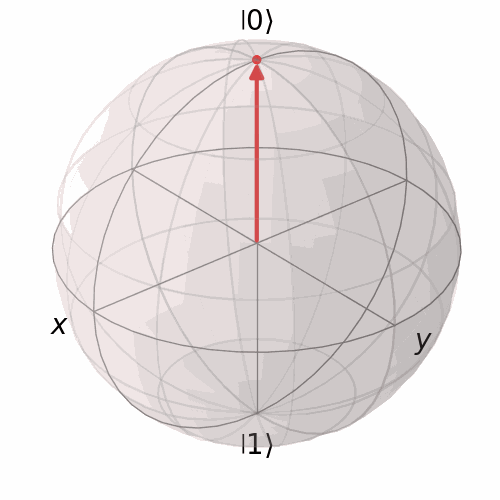

In [ ]:
Image(filename='test.gif')

<h2>
  <center>
    Two atoms driven with different pulse sequences
  </center>
</h2>

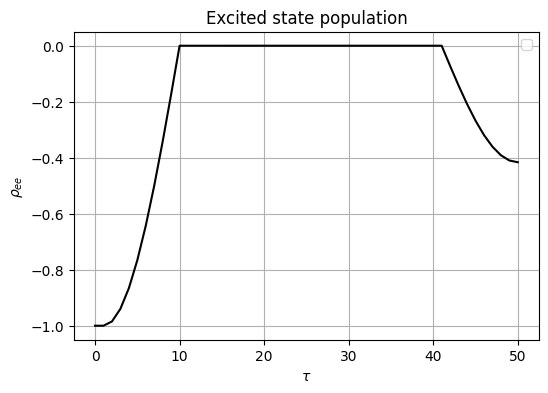

In [ ]:
tlist = np.linspace(0, 1, 10)
sys = N_dipole_system(2)
sys.H = qsum([sz/2 for sz in sys.sz_list])
sys.states = [sys.ket_ground]  # initial state

sys.evolve_pulse(tlist, Omega=[np.pi/2, 0])  # evolve with a Rabi frequency pi/2 for the times in tlist - Omega=pi/2 for t=0->1 is equivalent to a pi/2-pulse
sys.evolve(tlist)
sys.evolve_pulse(tlist, Omega=[0, np.pi])
sys.evolve(tlist)
sys.evolve_pulse(tlist, Omega=[np.pi/2, 0])

e_op = sys.sm_list[0].dag() * sys.sm_list[0] - sys.sm_list[0] * sys.sm_list[0].dag()
observables = [expect(e_op, s) for s in sys.states]

plt.figure(figsize=(6,4))
plt.plot(observables, color='black')
plt.grid(True)
plt.title('Excited state population')
plt.xlabel(r'$\tau$')
plt.ylabel(r'$\rho_{ee}$')
plt.legend(loc='upper right')

In [ ]:
sys.animate_bloch('different_pulse_sequences.gif', duration=10)

<ipython-input-29-ec7c93e2ec0d>:99: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  images.append(imageio.imread(filename))


In [1]:
Image(filename='different_pulse_sequences.gif')

NameError: ignored

# New Section

<h2>
    <center>
        Two non-interacting atoms with different frequencies
    </center>
</h2>

Suppose that we have two non-interacting atoms with different frequencies. The Hamiltonian of the system is

$$
H = \sum_{i}\omega_{i}\sigma_{i}^{\dagger}\sigma_{i}
$$

where $\omega_1$ and $\omega_2$ are the frequencies of the two atoms. For simplicity, we assume that the decay time is much longer than the time scale of the experiment.

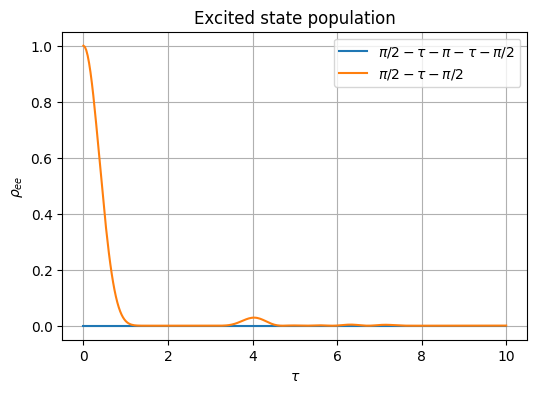

In [ ]:
omega = [1, 1.2, 1.4, 1.6, 1.8, 2, 2.2]
tlist = np.linspace(0, 10, 300)
sys = N_dipole_system(6)
sys.H = qsum([omega[i] * sys.sm_list[i].dag() * sys.sm_list[i] for i in range(sys.N)])

rho_e_ramsey = [sys.pulse_sequence(t, [np.pi/2, np.pi, np.pi/2]) for t in tlist]
rho_e_not_ramsey = [sys.pulse_sequence(t, [np.pi/2, np.pi/2]) for t in tlist]

plt.figure(figsize=(6,4))
plt.plot(tlist, rho_e_ramsey, label=r'$\pi/2-\tau-\pi-\tau-\pi/2$')
plt.plot(tlist, rho_e_not_ramsey, label=r'$\pi/2-\tau-\pi/2$')
plt.grid(True)
plt.title('Excited state population')
plt.xlabel(r'$\tau$')
plt.ylabel(r'$\rho_{ee}$')
plt.legend(loc='upper right')

In [ ]:
omega = [1, 1.2, 1.4, 1.6, 1.8, 2, 2.2]
sys = N_dipole_system(6)
sys.H = qsum([omega[i] * sys.sm_list[i].dag() * sys.sm_list[i] for i in range(sys.N)])
sys.pulse_sequence(4, [np.pi/2, np.pi, np.pi/2], points_pulse=20, points_evolve=40)
sys.animate_bloch('uncoupled_qubits.gif', duration=60)

<ipython-input-9-49c5112a85d7>:94: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  images.append(imageio.imread(filename))


In [ ]:
Image(filename='uncoupled_qubits.gif')

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
sys = N_dipole_system(6)
sys.H = qsum([omega[i] * sys.sm_list[i].dag() * sys.sm_list[i] for i in range(sys.N)])
sys.pulse_sequence(4, [np.pi/2, np.pi/2], points_pulse=20, points_evolve=40)
sys.animate_bloch('unccoupled_qubits_no_ramsey.gif', duration=60)
Image(filename='unccoupled_qubits_no_ramsey.gif')

<h2>
    <center>
        Dynamic decoupling of two interacting atoms
    </center>
</h2>

The Hamiltonian of the system is

$$
H=\sum_{i}\omega_{i}\sigma_{i}^{\dagger}\sigma_{i}+\sum_{i\ne j}J_{ij}\sigma_{i}^{\dagger}\sigma_{j}
$$


<IPython.core.display.Math object>

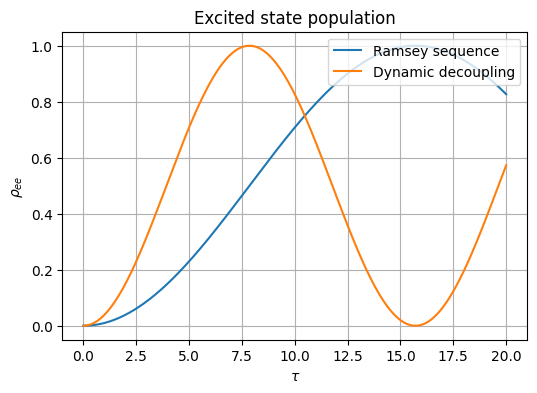

In [ ]:
### No decoupling ###

J = 0.1
tlist = np.linspace(0, 20, 300)
sys = N_dipole_system(2)
sys.H = sys.sm_list[0].dag() * sys.sm_list[0] + sys.sm_list[1].dag() * sys.sm_list[1] + \
        J * (sys.sm_list[0].dag() * sys.sm_list[1] + sys.sm_list[1].dag() * sys.sm_list[0])

rho_e_ramsey = [sys.pulse_sequence(t, [np.pi/2, np.pi, np.pi/2]) for t in tlist]
rho_e_decoupling = [sys.pulse_sequence(t, [np.pi/2, np.pi, np.pi, np.pi, np.pi/2]) for t in tlist]

tau_max = tlist[np.argmax(rho_e_ramsey)]
display(Math(r'\tau_\mathrm{max} = %.3f' % tau_max))

plt.figure(figsize=(6,4))
plt.plot(tlist, rho_e_ramsey, label=r'Ramsey sequence')
plt.plot(tlist, rho_e_decoupling, label=r'Dynamic decoupling')
plt.grid(True)
plt.title('Excited state population')
plt.xlabel(r'$\tau$')
plt.ylabel(r'$\rho_{ee}$')
plt.legend(loc='upper right')

In [ ]:
sys = N_dipole_system(2)
sys.H = sys.sm_list[0].dag() * sys.sm_list[0] + sys.sm_list[1].dag() * sys.sm_list[1] + \
        0.5 * (sys.sm_list[0].dag() * sys.sm_list[1] + sys.sm_list[1].dag() * sys.sm_list[0])
sys.pulse_sequence(np.pi, [np.pi/2, np.pi, np.pi/2], points_pulse=10, points_evolve=25)
sys.animate_bloch('dicke_model.gif', duration=60)

<ipython-input-9-49c5112a85d7>:94: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  images.append(imageio.imread(filename))


KeyboardInterrupt: ignored

In [ ]:
Image(filename='dicke_model.gif')

<h2>
    <center>
        Two interacting atoms with coulomb repulsion
    </center>
</h2>

The Hamiltonian of the system is

$$
H=\sum_{i}\omega_{i}\sigma_{i}^{\dagger}\sigma_{i}+\sum_{i\ne j}J_{ij}\sigma_{i}^{\dagger}\sigma_{i}\sigma_{j}^{\dagger}\sigma_{j}
$$


In [ ]:
tlist = np.linspace(0, 10, 300)
sys = N_dipole_system(2)
J = 0.5
sys.H = qsum([omega[i] * sys.sm_list[i].dag() * sys.sm_list[i] for i in range(sys.N)]) + \
        J * qsum([sys.sm_list[i].dag() * sys.sm_list[i] * sys.sm_list[j].dag() * sys.sm_list[j] for i in range(sys.N) for j in range(sys.N) if i != j])

rho_e_ramsey = [sys.pulse_sequence(t, [np.pi/2, np.pi, np.pi/2]) for t in tlist]
rho_e_not_ramsey = [sys.pulse_sequence(t, [np.pi/2, np.pi/2]) for t in tlist]

tau_max = tlist[np.argmax(rho_e_ramsey)]
display(Math(r'\tau_\mathrm{max} = %.3f' % tau_max))

plt.figure(figsize=(6,4))
plt.plot(tlist, rho_e_ramsey, label=r'$\pi/2-\tau-\pi-\tau-\pi/2$')
plt.plot(tlist, rho_e_not_ramsey, label=r'$\pi/2-\tau-\pi/2$')
plt.grid(True)
plt.title('Excited state population')
plt.xlabel(r'$\tau$')
plt.ylabel(r'$\rho_{ee}$')
plt.legend(loc='upper right')

In [ ]:
sys = N_dipole_system(2)
omega = [1, 1.2]
J = 0.5
sys.H = qsum([omega[i] * sys.sm_list[i].dag() * sys.sm_list[i] for i in range(sys.N)]) + \
        J * qsum([sys.sm_list[i].dag() * sys.sm_list[i] * sys.sm_list[j].dag() * sys.sm_list[j] for i in range(sys.N) for j in range(sys.N) if i != j])
sys.pulse_sequence(np.pi, [np.pi/2, np.pi, np.pi/2], points_pulse=10, points_evolve=25)
sys.animate_bloch('coulomb.gif', duration=60)

In [ ]:
Image(filename='coulomb.gif')